In [1]:
import os
import numpy as np

import torch

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.data.face_detection import get_fair_face, get_utk
from source.utils.metrics import accuracy, aod, eod, spd, get_prs, get_tprs, get_fprs

os.makedirs(PLOTS_PATH, exist_ok=True)

/system/apps/userenv/kschweig/disparate_benefits/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
method_seeds = [42, 142, 242, 342, 442]
dseed = 42

models = ["resnet18", "resnet34", "resnet50"]

targets = ["age", "gender", "race (old)", "race"]
# predicting race does not give high unfairness (with either pa) for eod and aod
# predicting gender also not too nice (only unfairness with age)
target = 0 # 0, 1, 2, 3
pa = 1 # 0, 1, 2, 3

In [ ]:
# no need to define targets and protected attributes, are queried directly afterwards
ff_train_ds, ff_test_ds = get_fair_face(binarize=True, augment=False)
utk_test_ds = get_utk(binarize=True)

run_path = os.path.join(RESULTS_PATH, f"fairface_target{target}_{models[0]}_mseed{method_seeds[0]}_dseed{dseed}")
fair_inds = torch.load(os.path.join(run_path, "fair_inds.pt"))
val_inds = torch.load(os.path.join(run_path, "val_inds.pt"))

print(len(fair_inds), len(val_inds), len(ff_test_ds), len(utk_test_ds))

# get targets and protected attributes
y_fair_t = ff_train_ds.targets[target, fair_inds]
a_fair_t = ff_train_ds.targets[pa, fair_inds]
y_val_t = ff_train_ds.targets[target, val_inds]
a_val_t = ff_train_ds.targets[pa, val_inds]
y_ff_test_t = ff_test_ds.targets[target]
a_ff_test_t = ff_test_ds.targets[pa]
y_utk_test_t = utk_test_ds.targets[target]
a_utk_test_t = utk_test_ds.targets[pa]

# get fraction of protected attribute for testsets
p_a_ff_test = a_ff_test_t.float().mean().item() * 100
p_a_utk_test = a_utk_test_t.float().mean().item() * 100
print(p_a_ff_test, p_a_utk_test)

In [4]:
# load probits
fair_probits, val_probits, ff_test_probits, utk_test_probits = list(), list(), list(), list()
for mseed in method_seeds:
    for model in models:
        path = os.path.join(RESULTS_PATH, f"fairface_target{target}_{model}_mseed{mseed}_dseed{dseed}")

        fair_probits.append(torch.load(os.path.join(path, f"fair_probits_t{target}.pt")))
        val_probits.append(torch.load(os.path.join(path, f"val_probits_t{target}.pt")))
        ff_test_probits.append(torch.load(os.path.join(path, f"ff_test_probits_t{target}.pt")))
        utk_test_probits.append(torch.load(os.path.join(path, f"utk_test_probits_t{target}.pt")))

# make array and reshape
fair_probits = torch.stack(fair_probits).reshape(len(method_seeds), -1, len(fair_inds), 2)
val_probits = torch.stack(val_probits).reshape(len(method_seeds), -1, len(val_inds), 2)
ff_test_probits = torch.stack(ff_test_probits).reshape(len(method_seeds), -1, len(y_ff_test_t), 2)
utk_test_probits = torch.stack(utk_test_probits).reshape(len(method_seeds), -1, len(y_utk_test_t), 2)
# shuffle second dimension
torch.manual_seed(42)
fair_probits = fair_probits[:, torch.randperm(fair_probits.size(1))]
val_probits = val_probits[:, torch.randperm(val_probits.size(1))]
ff_test_probits = ff_test_probits[:, torch.randperm(ff_test_probits.size(1))]
utk_test_probits = utk_test_probits[:, torch.randperm(utk_test_probits.size(1))]

In [5]:
# calculate accuracies and fairness measures
fair_accs, val_accs, ff_test_accs, utk_test_accs = list(), list(), list(), list()
fair_spds, val_spds, ff_test_spds, utk_test_spds = list(), list(), list(), list()
fair_eods, val_eods, ff_test_eods, utk_test_eods = list(), list(), list(), list()
fair_aods, val_aods, ff_test_aods, utk_test_aods = list(), list(), list(), list()

for m in range(len(method_seeds)):
    fair_accs.append([accuracy(p.argmax(dim=1), y_fair_t) for p in fair_probits[m]])
    val_accs.append([accuracy(p.argmax(dim=1), y_val_t) for p in val_probits[m]])
    ff_test_accs.append([accuracy(p.argmax(dim=1), y_ff_test_t) for p in ff_test_probits[m]])
    utk_test_accs.append([accuracy(p.argmax(dim=1), y_utk_test_t) for p in utk_test_probits[m]])

    fair_spds.append([spd(p.argmax(dim=1), a_fair_t) for p in fair_probits[m]])
    val_spds.append([spd(p.argmax(dim=1), a_val_t) for p in val_probits[m]])
    ff_test_spds.append([spd(p.argmax(dim=1), a_ff_test_t) for p in ff_test_probits[m]])
    utk_test_spds.append([spd(p.argmax(dim=1), a_utk_test_t) for p in utk_test_probits[m]])
    
    fair_eods.append([eod(p.argmax(dim=1), y_fair_t, a_fair_t) for p in fair_probits[m]])
    val_eods.append([eod(p.argmax(dim=1), y_val_t, a_val_t) for p in val_probits[m]])
    ff_test_eods.append([eod(p.argmax(dim=1), y_ff_test_t, a_ff_test_t) for p in ff_test_probits[m]])
    utk_test_eods.append([eod(p.argmax(dim=1), y_utk_test_t, a_utk_test_t) for p in utk_test_probits[m]])

    fair_aods.append([aod(p.argmax(dim=1), y_fair_t, a_fair_t) for p in fair_probits[m]])
    val_aods.append([aod(p.argmax(dim=1), y_val_t, a_val_t) for p in val_probits[m]])
    ff_test_aods.append([aod(p.argmax(dim=1), y_ff_test_t, a_ff_test_t) for p in ff_test_probits[m]])
    utk_test_aods.append([aod(p.argmax(dim=1), y_utk_test_t, a_utk_test_t) for p in utk_test_probits[m]])

In [6]:
ff_test_m_accs, utk_test_m_accs = list(), list()
ff_test_m_spds, utk_test_m_spds = list(), list()
ff_test_m_eods, utk_test_m_eods = list(), list()
ff_test_m_aods, utk_test_m_aods = list(), list()

for m in range(len(method_seeds)):
    ff_test_m_accs.append(accuracy(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), y_ff_test_t))
    utk_test_m_accs.append(accuracy(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), y_utk_test_t))

    ff_test_m_spds.append(spd(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), a_ff_test_t))
    utk_test_m_spds.append(spd(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), a_utk_test_t))
    
    ff_test_m_eods.append(eod(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), y_ff_test_t, a_ff_test_t))
    utk_test_m_eods.append(eod(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), y_utk_test_t, a_utk_test_t))

    ff_test_m_aods.append(aod(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), y_ff_test_t, a_ff_test_t))
    utk_test_m_aods.append(aod(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), y_utk_test_t, a_utk_test_t))

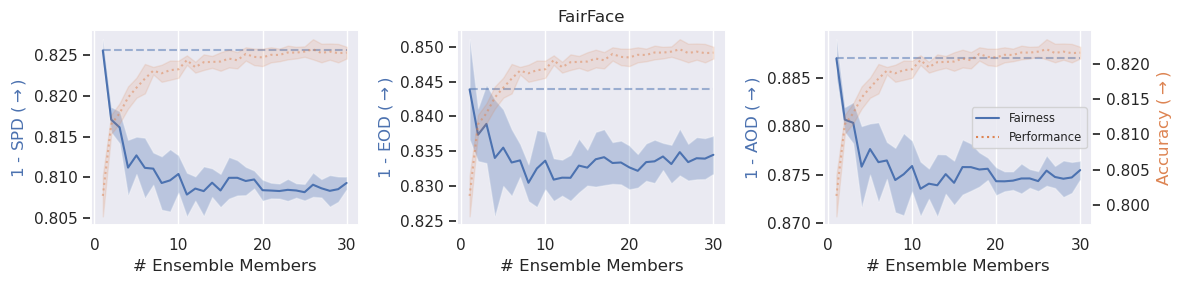

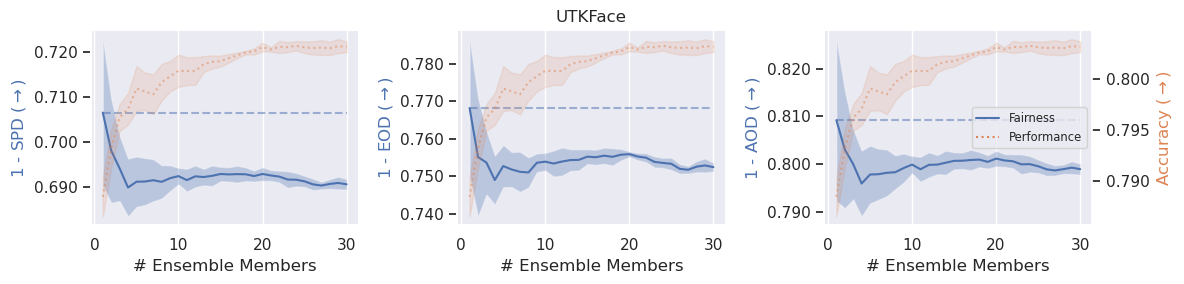

In [7]:
ensemble_members = list(range(1, len(ff_test_probits[0]) + 1))

ff_test_fm_accs, utk_test_fm_accs = list(), list()
ff_test_fm_spds, utk_test_fm_spds = list(), list()
ff_test_fm_eods, utk_test_fm_eods = list(), list()
ff_test_fm_aods, utk_test_fm_aods = list(), list()

for m in range(len(method_seeds)):

    ff_test_fm_accs_, utk_test_fm_accs_ = list(), list()
    ff_test_fm_spds_, utk_test_fm_spds_ = list(), list()
    ff_test_fm_eods_, utk_test_fm_eods_ = list(), list()
    ff_test_fm_aods_, utk_test_fm_aods_ = list(), list()

    for em in ensemble_members:
        preds = torch.mean(ff_test_probits[m][:em], dim=0).argmax(dim=1)
        ff_test_fm_accs_.append(accuracy(preds, y_ff_test_t))
        ff_test_fm_spds_.append(1 - spd(preds, a_ff_test_t))
        ff_test_fm_eods_.append(1 - eod(preds, y_ff_test_t, a_ff_test_t))
        ff_test_fm_aods_.append(1 - aod(preds, y_ff_test_t, a_ff_test_t))

        preds = torch.mean(utk_test_probits[m][:em], dim=0).argmax(dim=1)
        utk_test_fm_accs_.append(accuracy(preds, y_utk_test_t))
        utk_test_fm_spds_.append(1 - spd(preds, a_utk_test_t))
        utk_test_fm_eods_.append(1 - eod(preds, y_utk_test_t, a_utk_test_t))
        utk_test_fm_aods_.append(1 - aod(preds, y_utk_test_t, a_utk_test_t))

    ff_test_fm_accs.append(ff_test_fm_accs_)
    utk_test_fm_accs.append(utk_test_fm_accs_)
    ff_test_fm_spds.append(ff_test_fm_spds_)
    utk_test_fm_spds.append(utk_test_fm_spds_)
    ff_test_fm_eods.append(ff_test_fm_eods_)
    utk_test_fm_eods.append(utk_test_fm_eods_)
    ff_test_fm_aods.append(ff_test_fm_aods_)
    utk_test_fm_aods.append(utk_test_fm_aods_)

ff_test_fm_accs = np.asarray(ff_test_fm_accs)
utk_test_fm_accs = np.asarray(utk_test_fm_accs)
ff_test_fm_spds = np.asarray(ff_test_fm_spds)
utk_test_fm_spds = np.asarray(utk_test_fm_spds)
ff_test_fm_eods = np.asarray(ff_test_fm_eods)
utk_test_fm_eods = np.asarray(utk_test_fm_eods)
ff_test_fm_aods = np.asarray(ff_test_fm_aods)
utk_test_fm_aods = np.asarray(utk_test_fm_aods)

acc_axs = list()
f, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(ensemble_members, np.mean(ff_test_fm_spds, axis=0), "-")
axs[0].fill_between(ensemble_members, 
                       np.mean(ff_test_fm_spds, axis=0) - np.std(ff_test_fm_spds, axis=0), 
                       np.mean(ff_test_fm_spds, axis=0) + np.std(ff_test_fm_spds, axis=0), alpha=0.3)
axs[0].hlines(np.mean(ff_test_fm_spds, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[0].twinx())
axs[0].set_ylabel("1 - SPD ($\\rightarrow$)", color="C0")
axs[1].plot(ensemble_members, np.mean(ff_test_fm_eods, axis=0), "-")
axs[1].fill_between(ensemble_members,
                       np.mean(ff_test_fm_eods, axis=0) - np.std(ff_test_fm_eods, axis=0), 
                       np.mean(ff_test_fm_eods, axis=0) + np.std(ff_test_fm_eods, axis=0), alpha=0.3)
axs[1].hlines(np.mean(ff_test_fm_eods, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[1].twinx())
axs[1].set_ylabel("1 - EOD ($\\rightarrow$)", color="C0")
axs[2].plot(ensemble_members, np.mean(ff_test_fm_aods, axis=0), "-")
axs[2].fill_between(ensemble_members,
                       np.mean(ff_test_fm_aods, axis=0) - np.std(ff_test_fm_aods, axis=0), 
                       np.mean(ff_test_fm_aods, axis=0) + np.std(ff_test_fm_aods, axis=0), alpha=0.3)
axs[2].hlines(np.mean(ff_test_fm_aods, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[2].twinx())
axs[2].set_ylabel("1 - AOD ($\\rightarrow$)", color="C0")

axs[1].set_title("FairFace")

for ax in acc_axs:
    ax.plot(ensemble_members, np.mean(ff_test_fm_accs, axis=0), ":", c="C1", alpha=0.5)
    ax.fill_between(ensemble_members, 
                    np.mean(ff_test_fm_accs, axis=0) - np.std(ff_test_fm_accs, axis=0), 
                    np.mean(ff_test_fm_accs, axis=0) + np.std(ff_test_fm_accs, axis=0), alpha=0.15, color="C1")

handle_1 = mlines.Line2D([], [], color='C0', linestyle="solid", label='Fairness')
handle_2 = mlines.Line2D([], [], color='C1', linestyle="dotted", label='Performance')
axs[2].legend(handles=[handle_1, handle_2], loc="center right", fontsize="x-small")

for i, ax in enumerate(axs.flatten()):
    ax.yaxis.grid(False)
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
for a, ax in enumerate(acc_axs):
    ax.yaxis.grid(False)
    if a == 2:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        ax.set_ylabel("Accuracy ($\\rightarrow$)", color="C1")
    else:
        ax.set_yticks([])

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_hetens_ff.pdf"))
plt.show()

acc_axs = list()
f, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].plot(ensemble_members, np.mean(utk_test_fm_spds, axis=0), "-")
axs[0].fill_between(ensemble_members,
                       np.mean(utk_test_fm_spds, axis=0) - np.std(utk_test_fm_spds, axis=0), 
                       np.mean(utk_test_fm_spds, axis=0) + np.std(utk_test_fm_spds, axis=0), alpha=0.3)
axs[0].hlines(np.mean(utk_test_fm_spds, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[0].twinx())
axs[0].set_ylabel("1 - SPD ($\\rightarrow$)", color="C0")
axs[1].plot(ensemble_members, np.mean(utk_test_fm_eods, axis=0), "-")
axs[1].fill_between(ensemble_members,
                       np.mean(utk_test_fm_eods, axis=0) - np.std(utk_test_fm_eods, axis=0), 
                       np.mean(utk_test_fm_eods, axis=0) + np.std(utk_test_fm_eods, axis=0), alpha=0.3)
axs[1].hlines(np.mean(utk_test_fm_eods, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[1].twinx())
axs[1].set_ylabel("1 - EOD ($\\rightarrow$)", color="C0")
axs[2].plot(ensemble_members, np.mean(utk_test_fm_aods, axis=0), "-")
axs[2].fill_between(ensemble_members,
                       np.mean(utk_test_fm_aods, axis=0) - np.std(utk_test_fm_aods, axis=0), 
                       np.mean(utk_test_fm_aods, axis=0) + np.std(utk_test_fm_aods, axis=0), alpha=0.3)
axs[2].hlines(np.mean(utk_test_fm_aods, axis=0)[0], ensemble_members[0], ensemble_members[-1], color="C0", linestyle="--", alpha=0.5)
acc_axs.append(axs[2].twinx())
axs[2].set_ylabel("1 - AOD ($\\rightarrow$)", color="C0")

axs[1].set_title("UTKFace")

for ax in acc_axs:
    ax.plot(ensemble_members, np.mean(utk_test_fm_accs, axis=0), ":", c="C1", alpha=0.5)
    ax.fill_between(ensemble_members, 
                    np.mean(utk_test_fm_accs, axis=0) - np.std(utk_test_fm_accs, axis=0), 
                    np.mean(utk_test_fm_accs, axis=0) + np.std(utk_test_fm_accs, axis=0), alpha=0.15, color="C1")

handle_1 = mlines.Line2D([], [], color='C0', linestyle="solid", label='Fairness')
handle_2 = mlines.Line2D([], [], color='C1', linestyle="dotted", label='Performance')
axs[2].legend(handles=[handle_1, handle_2], loc="center right", fontsize="x-small")

for i, ax in enumerate(axs.flatten()):
    ax.yaxis.grid(False)
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
for a, ax in enumerate(acc_axs):
    ax.yaxis.grid(False)
    if a == 2:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        ax.set_ylabel("Accuracy ($\\rightarrow$)", color="C1")
    else:
        ax.set_yticks([])

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_hetens_utk.pdf"))
plt.show()

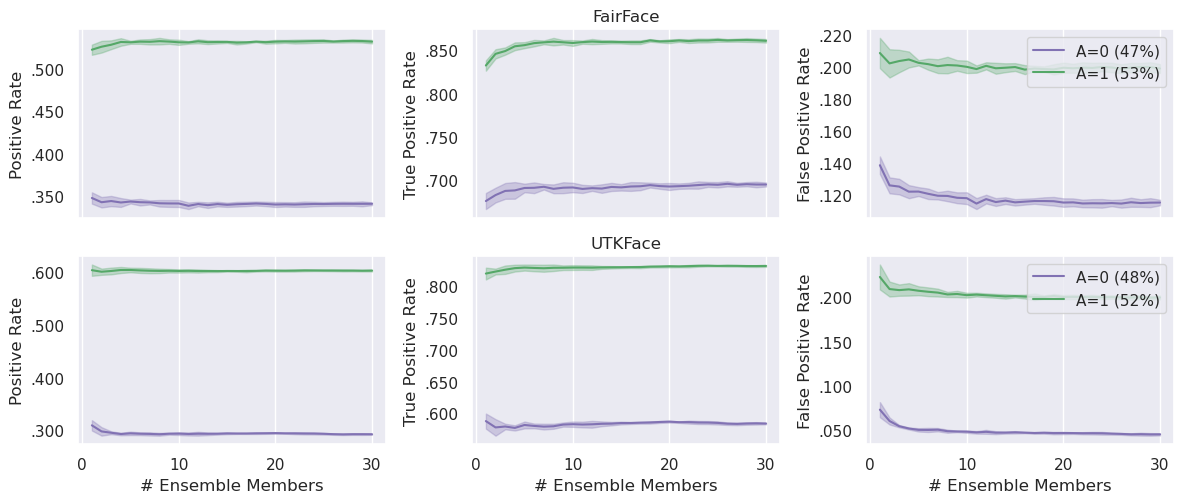

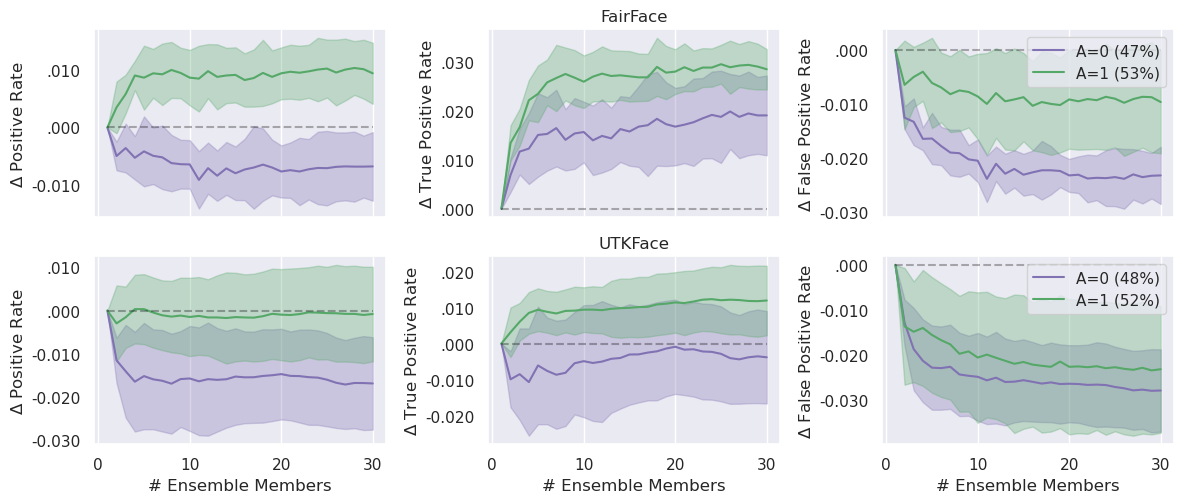

In [8]:
ensemble_members = list(range(1, len(ff_test_probits[0]) + 1))

for delta in [False, True]:

    ff_test_fm_prs_1, ff_test_fm_prs_0 = list(), list()
    ff_test_fm_tprs_1, ff_test_fm_tprs_0 = list(), list()
    ff_test_fm_fprs_1, ff_test_fm_fprs_0 = list(), list()
    utk_test_fm_prs_1, utk_test_fm_prs_0 = list(), list()
    utk_test_fm_tprs_1, utk_test_fm_tprs_0 = list(), list()
    utk_test_fm_fprs_1, utk_test_fm_fprs_0 = list(), list()

    for m in range(len(method_seeds)):

        ff_test_fm_prs_1_, ff_test_fm_prs_0_ = list(), list()
        ff_test_fm_tprs_1_, ff_test_fm_tprs_0_ = list(), list()
        ff_test_fm_fprs_1_, ff_test_fm_fprs_0_ = list(), list()
        utk_test_fm_prs_1_, utk_test_fm_prs_0_ = list(), list()
        utk_test_fm_tprs_1_, utk_test_fm_tprs_0_ = list(), list()
        utk_test_fm_fprs_1_, utk_test_fm_fprs_0_ = list(), list()

        for em in ensemble_members:
            preds = torch.mean(ff_test_probits[m][:em], dim=0).argmax(dim=1)
            pr1, pr0 = get_prs(preds, a_ff_test_t)
            tpr1, tpr0 = get_tprs(preds, y_ff_test_t, a_ff_test_t)
            fpr1, fpr0 = get_fprs(preds, y_ff_test_t, a_ff_test_t)
            ff_test_fm_prs_1_.append(pr1)
            ff_test_fm_prs_0_.append(pr0)
            ff_test_fm_tprs_1_.append(tpr1)
            ff_test_fm_tprs_0_.append(tpr0)
            ff_test_fm_fprs_1_.append(fpr1)
            ff_test_fm_fprs_0_.append(fpr0)

            preds = torch.mean(utk_test_probits[m][:em], dim=0).argmax(dim=1)
            pr1, pr0 = get_prs(preds, a_utk_test_t)
            tpr1, tpr0 = get_tprs(preds, y_utk_test_t, a_utk_test_t)
            fpr1, fpr0 = get_fprs(preds, y_utk_test_t, a_utk_test_t)
            utk_test_fm_prs_1_.append(pr1)
            utk_test_fm_prs_0_.append(pr0)
            utk_test_fm_tprs_1_.append(tpr1)
            utk_test_fm_tprs_0_.append(tpr0)
            utk_test_fm_fprs_1_.append(fpr1)
            utk_test_fm_fprs_0_.append(fpr0)
            
        if delta:
            ff_test_fm_prs_1.append([t - ff_test_fm_prs_1_[0] for t in ff_test_fm_prs_1_])
            ff_test_fm_prs_0.append([t - ff_test_fm_prs_0_[0] for t in ff_test_fm_prs_0_])
            ff_test_fm_tprs_1.append([t - ff_test_fm_tprs_1_[0] for t in ff_test_fm_tprs_1_])
            ff_test_fm_tprs_0.append([t - ff_test_fm_tprs_0_[0] for t in ff_test_fm_tprs_0_])
            ff_test_fm_fprs_1.append([t - ff_test_fm_fprs_1_[0] for t in ff_test_fm_fprs_1_])
            ff_test_fm_fprs_0.append([t - ff_test_fm_fprs_0_[0] for t in ff_test_fm_fprs_0_])

            utk_test_fm_prs_1.append([t - utk_test_fm_prs_1_[0] for t in utk_test_fm_prs_1_])
            utk_test_fm_prs_0.append([t - utk_test_fm_prs_0_[0] for t in utk_test_fm_prs_0_])
            utk_test_fm_tprs_1.append([t - utk_test_fm_tprs_1_[0] for t in utk_test_fm_tprs_1_])
            utk_test_fm_tprs_0.append([t - utk_test_fm_tprs_0_[0] for t in utk_test_fm_tprs_0_])
            utk_test_fm_fprs_1.append([t - utk_test_fm_fprs_1_[0] for t in utk_test_fm_fprs_1_])
            utk_test_fm_fprs_0.append([t - utk_test_fm_fprs_0_[0] for t in utk_test_fm_fprs_0_])
        else:
            ff_test_fm_prs_1.append(ff_test_fm_prs_1_)
            ff_test_fm_prs_0.append(ff_test_fm_prs_0_)
            ff_test_fm_tprs_1.append(ff_test_fm_tprs_1_)
            ff_test_fm_tprs_0.append(ff_test_fm_tprs_0_)
            ff_test_fm_fprs_1.append(ff_test_fm_fprs_1_)
            ff_test_fm_fprs_0.append(ff_test_fm_fprs_0_)

            utk_test_fm_prs_1.append(utk_test_fm_prs_1_)
            utk_test_fm_prs_0.append(utk_test_fm_prs_0_)
            utk_test_fm_tprs_1.append(utk_test_fm_tprs_1_)
            utk_test_fm_tprs_0.append(utk_test_fm_tprs_0_)
            utk_test_fm_fprs_1.append(utk_test_fm_fprs_1_)
            utk_test_fm_fprs_0.append(utk_test_fm_fprs_0_)

    ff_test_fm_prs_1 = np.asarray(ff_test_fm_prs_1)
    ff_test_fm_prs_0 = np.asarray(ff_test_fm_prs_0)
    ff_test_fm_tprs_1 = np.asarray(ff_test_fm_tprs_1)
    ff_test_fm_tprs_0 = np.asarray(ff_test_fm_tprs_0)
    ff_test_fm_fprs_1 = np.asarray(ff_test_fm_fprs_1)
    ff_test_fm_fprs_0 = np.asarray(ff_test_fm_fprs_0)

    utk_test_fm_prs_1 = np.asarray(utk_test_fm_prs_1)
    utk_test_fm_prs_0 = np.asarray(utk_test_fm_prs_0)
    utk_test_fm_tprs_1 = np.asarray(utk_test_fm_tprs_1)
    utk_test_fm_tprs_0 = np.asarray(utk_test_fm_tprs_0)
    utk_test_fm_fprs_1 = np.asarray(utk_test_fm_fprs_1)
    utk_test_fm_fprs_0 = np.asarray(utk_test_fm_fprs_0)

    f, axs = plt.subplots(2, 3, figsize=(12, 5.2), sharex=True)
    for t, test_pr in enumerate([ff_test_fm_prs_0, ff_test_fm_prs_1]):
        axs[0, 0].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                       label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)")
        axs[0, 0].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[0, 0].set_ylabel("$\Delta$ Positive Rate" if delta else "Positive Rate")
    for t, test_tpr in enumerate([ff_test_fm_tprs_0, ff_test_fm_tprs_1]):
        axs[0, 1].plot(ensemble_members, np.mean(test_tpr, axis=0), "-", color=["C4", "C2"][t], 
                       label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)")
        axs[0, 1].fill_between(ensemble_members,
                            np.mean(test_tpr, axis=0) - np.std(test_tpr, axis=0), 
                            np.mean(test_tpr, axis=0) + np.std(test_tpr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[0, 1].set_ylabel("$\Delta$ True Positive Rate" if delta else "True Positive Rate")
    for t, test_fpr in enumerate([ff_test_fm_fprs_0, ff_test_fm_fprs_1]):
        axs[0, 2].plot(ensemble_members, np.mean(test_fpr, axis=0), "-", color=["C4", "C2"][t], 
                       label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)")
        axs[0, 2].fill_between(ensemble_members,
                            np.mean(test_fpr, axis=0) - np.std(test_fpr, axis=0), 
                            np.mean(test_fpr, axis=0) + np.std(test_fpr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[0, 2].set_ylabel("$\Delta$ False Positive Rate" if delta else "False Positive Rate")
    axs[0, 2].legend(loc="upper right")
    for t, test_pr in enumerate([utk_test_fm_prs_0, utk_test_fm_prs_1]):
        axs[1, 0].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                       label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)")
        axs[1, 0].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[1, 0].set_ylabel("$\Delta$ Positive Rate" if delta else "Positive Rate")
    for t, test_tpr in enumerate([utk_test_fm_tprs_0, utk_test_fm_tprs_1]):
        axs[1, 1].plot(ensemble_members, np.mean(test_tpr, axis=0), "-", color=["C4", "C2"][t], 
                       label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)")
        axs[1, 1].fill_between(ensemble_members,
                            np.mean(test_tpr, axis=0) - np.std(test_tpr, axis=0), 
                            np.mean(test_tpr, axis=0) + np.std(test_tpr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[1, 1].set_ylabel("$\Delta$ True Positive Rate" if delta else "True Positive Rate")
    
    for t, test_fpr in enumerate([utk_test_fm_fprs_0, utk_test_fm_fprs_1]):
        axs[1, 2].plot(ensemble_members, np.mean(test_fpr, axis=0), "-", color=["C4", "C2"][t], 
                       label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)")
        axs[1, 2].fill_between(ensemble_members,
                            np.mean(test_fpr, axis=0) - np.std(test_fpr, axis=0), 
                            np.mean(test_fpr, axis=0) + np.std(test_fpr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[1, 2].set_ylabel("$\Delta$ False Positive Rate" if delta else "False Positive Rate")
    axs[1, 2].legend(loc="upper right")

    axs[0, 1].set_title("FairFace")
    axs[1, 1].set_title("UTKFace")

    for i, ax in enumerate(axs.flatten()):
        ax.yaxis.grid(False)
        if i >= 3:
            ax.set_xlabel("# Ensemble Members")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}".lstrip("0")))
        if delta:
            ax.hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)

    f.tight_layout()
    if delta:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_hetens_delta_rates.pdf"))
    else:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_hetens_rates.pdf"))
    plt.show()